In [1]:
close all;clear;clc;
addpath('../../code/functions/');

fcell={'breast\','ganglio\'};

% for kcell=1:length(fcell)
for kcell=1
f=fcell{kcell};
lstfiles=ls([f,'*.rf']);
tot=size(lstfiles,1);



Se carga la data rf y se calcula la envolvente


In [2]:
% for i=1:tot
% for i=[1 3]
for i=[1]
    fname=strtrim(lstfiles(i,:));
    [rf,feat] = RPread([f,fname]);
    env_rf=abs(hilbert(rf));

    [x, z, z_interp, X, Z, X_interp, Z_interp] = xz_interp_grid(rf, feat);
    res = x(2) - x(1);



Se comprime logarítmicamente la envolvente interpolada: $\mathrm{comp}\_\mathrm{env}=a_0 \log \left(\mathrm{env}\right)+b_0$ (en la función <samp>getab(env_rf,j)</samp>, <samp>j</samp> es el índice de la forma de calcular automáticamente $a_0$ y $b_0$ . Luego, se interpola el resultado para tener la misma resolución en ambas dimensiones.


In [3]:
% for j=1:5
for j=1
    [a_0,b_0,comp_env]=getab(env_rf,j);
    % comp_env=20*log10(env_rf/max(env_rf(:)));

    comp_env_interp = interp2(X,Z,comp_env,X_interp,Z_interp);
    env_rf_interp = interp2(X,Z,env_rf,X_interp,Z_interp);

    comp_env_interp(comp_env_interp<0) = 0;


Se escoge <samp>n=57</samp> para el tamaño de ventana que se extraerá para el algoritmo.


In [4]:
    [rows, cols] = size(env_rf_interp);
    n=57;
    m=n;

    % Preallocate output matrix
    output_rows = rows - n + 1;
    output_cols = cols - m + 1;

    % metrics
    k_matrix = zeros(output_rows, output_cols);
    beta_matrix = zeros(output_rows, output_cols);
    validRS = zeros(size(k_matrix));
    validRS_uncomp = zeros(size(k_matrix));
    validRS_uncomp_corr = zeros(size(k_matrix));
    a_matrix_valid=[];
    a_matrix_valid_uncomp=[];
    a_matrix_valid_uncomp_corr=[];

    % plot
    visualized_image=zeros(size(comp_env_interp));
    visualized_image_uncomp=zeros(size(comp_env_interp));
    visualized_image_uncomp_corr=zeros(size(comp_env_interp));

    % coeff
    a_matrix = zeros(output_rows, output_cols);


Se realiza el siguiente procedimiento para la envolvente original, el resultado de la compresión logarítmica, y luego con un valor "corregido" de esta última (se explicará más adelante).

-  Para cada ventana (a excepción de la envolvente original), se calcula $a_0$ (<samp>a_prager</samp>). Con el valor obtenido, se intenta regresar a la envolvente sin compresión: $\exp \left(\frac{z-b_0 }{a_{\mathrm{prager}} }\right)$ . En este caso, se considera $b_0 =0$ , ya que a final de cuentas $b_0$ actúa como un offset.
-  Luego, se calcula <samp>S</samp> (skewness) y <samp>R</samp> (SNR). Ambos valores serán utilizados para calcular $k$ y $\beta$ (ver prager2003decompression, página 3 y apéndice C).
-  Se consideran como válidas las ventanas para las cuales $0\le k<1\wedge 0\le \beta <1/4$ (prager2003decompression).

El valor "corregido" se refiere a utilizar $R_c =R-0\ldotp 07$ y $S_c =S-0\ldotp 95$ para el cálculo de $k$ y $\beta$ .


In [5]:
    % Loop through each window
    tic;
    for ni = 1:output_rows
        for mi = 1:output_cols
            % envelope
            window = env_rf_interp(ni:ni+n-1, mi:mi+m-1);
            window_v=window(:);
            S = skewness(window_v);
            R = mean(window_v)/std(window_v);

            % compressed
            window_comp=comp_env_interp(ni:ni+n-1, mi:mi+m-1);
            window_comp_v=window_comp(:);
            [a_prager,uncomp_env_window]=est_prager(window_comp_v,a_0,0,false);
            a_matrix(ni, mi) = a_prager;

            S_uncomp = skewness(uncomp_env_window);
            R_uncomp = mean(uncomp_env_window)/std(uncomp_env_window);

            % k beta calculation

            % original envelope
            try
                [k, beta] = getkbeta(R, S);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS(ni,mi)=1;
                    visualized_image(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid=[a_matrix_valid,a_matrix(ni,mi)];
                end
            catch exception
            end

            % compressed
            try
                [k, beta] = getkbeta(R_uncomp, S_uncomp);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS_uncomp(ni,mi)=1;
                    visualized_image_uncomp(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid_uncomp=[a_matrix_valid_uncomp,a_matrix(ni,mi)];
                end
            catch exception
            end
            % compressed ("corrected")
            try
                [k, beta] = getkbeta(R_uncomp-0.07, S_uncomp-0.95);
                % k_matrix(ni, mi)=k;
                % beta_matrix(ni, mi)=beta;
                if 0<=k && k<1 && 0<=beta && beta<0.25
                    validRS_uncomp_corr(ni,mi)=1;
                    visualized_image_uncomp_corr(ni:ni+n-1, mi:mi+m-1) = comp_env_interp(ni:ni+n-1, mi:mi+m-1);
                    a_matrix_valid_uncomp_corr=[a_matrix_valid_uncomp_corr,a_matrix(ni,mi)];
                end
            catch exception
            end
        end
    end
    t_tot=toc;


En la figura, se muestra:

-  La imagen en modo B
-  Las ventanas válidas utilizando el envelope original (ground truth)
-  Las ventanas válidas utilizando el valor al invertir la compresión logarítmica
-  Las ventanas válidas utilizando los valores "corregidos" de <samp>R</samp> y <samp>S</samp> (que da malos resultados).

Se muestran 3 estimaciones:

-  **<samp>junto</samp>** **(o** **<samp>junto1</samp>****):** se utiliza la combinación de todas las máscaras para la estimación de $a_0$ .
-  **<samp>junto2</samp>****:** se utiliza la unión de todas las máscaras, a excepción de la capa superior (más cercana al transductor).
-  **<samp>separado</samp>****:** se utiliza el promedio de valores de $a_0$ estimados en cada ventana individual.

El hecho de que <samp>junto2</samp> obtenga mejores valores que <samp>junto1</samp>, y que <samp>separado</samp> tenga mejores valores que <samp>junto</samp>, puede significar que el método empeora al utilizar regiones con distinta atenuación.



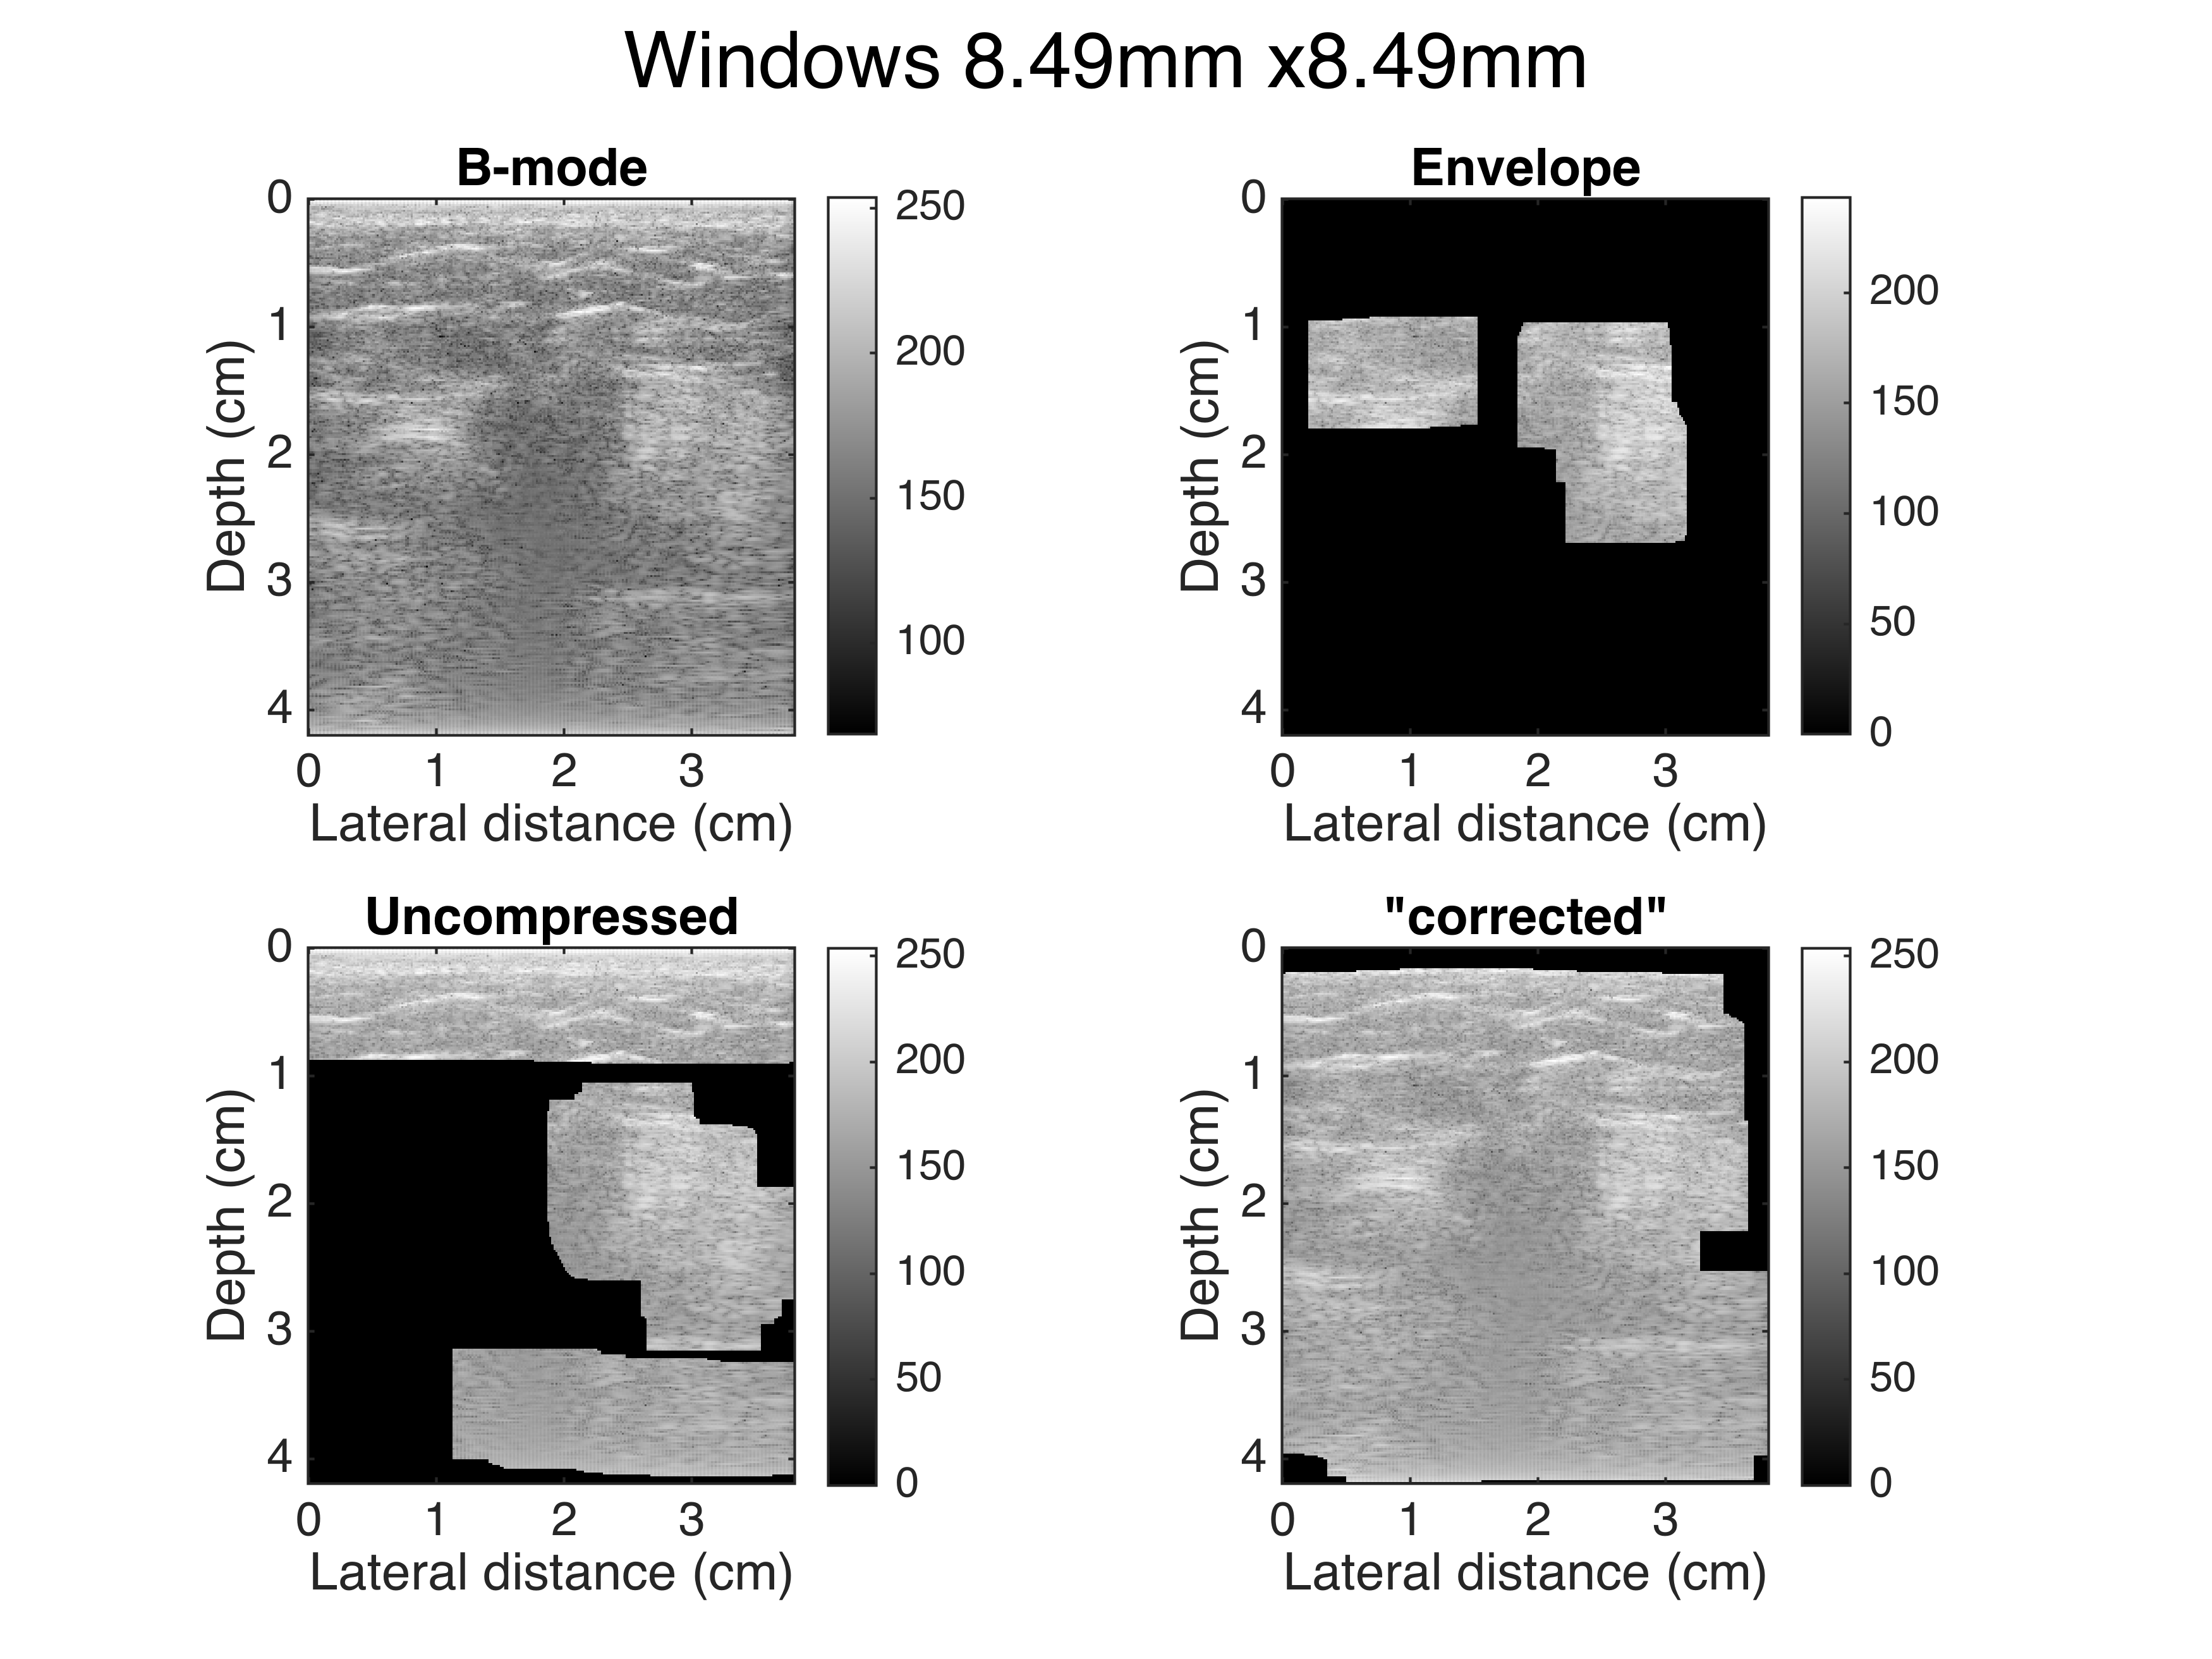

breast:1/514(1) : 362.6986s
Ground truth coeff: 20.2499
Envelope:
Junto   : 24.5507 (+21.239%%)
Separado: 22.0271 (+8.7761%%)
Uncompressed:
Junto1  : 32.8868 (+62.405%%)
Junto2  : 23.8958 (+18.004%%)
Separado: 19.7303 (-2.5663%%)
Corrected:
Junto   : 29.2926 (+44.655%%)
Separado: 20.6681 (+2.0652%%)

In [6]:
    figure;
    ax=subplot(2,2,1);
    imagesc(100*x,100*z_interp,comp_env_interp);colormap(ax,gray);colorbar;axis image;
    title('B-mode');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,2);
    imagesc(100*x,100*z_interp,visualized_image);colormap(ax,gray);colorbar;axis image;
    title('Envelope');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,3);
    imagesc(100*x,100*z_interp,visualized_image_uncomp);colormap(ax,gray);colorbar;axis image;
    title('Uncompressed');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    ax=subplot(2,2,4);
    imagesc(100*x,100*z_interp,visualized_image_uncomp_corr);colormap(ax,gray);colorbar;axis image;
    title('"corrected"');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');


    % ax=subplot(2,2,3);
    % imagesc(100*x(round(n/2):round(end-n/2)),100*z_interp(round(m/2):round(end-m/2)),k_matrix);
    % colormap(ax,slanCM(114));colorbar;clim([1 3]);axis image;
    % title('k');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');
    %
    % ax=subplot(2,2,4);
    % imagesc(100*x(round(n/2):round(end-n/2)),100*z_interp(round(m/2):round(end-m/2)),beta_matrix);
    % colormap(ax,slanCM(114));colorbar;clim([1 3]);axis image;
    % title('\beta');ylabel('Depth (cm)');xlabel('Lateral distance (cm)');

    sgtitle(['Windows ',num2str(n*res*1e3,3),'mm x',num2str(m*res*1e3,3),'mm']);
    % keyboard;

    disp([f(1:end-1),':',num2str(i),'/',num2str(tot),'(',num2str(j),') : ',num2str(t_tot),'s']);
    disp(['Ground truth coeff: ',num2str(a_0)]);
    disp('Envelope:');
    [a_prager_fin,~]=est_prager(comp_env_interp(visualized_image~=0),a_0,0,false);
    disp(['Junto   : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid))),'%)']);

    disp('Uncompressed:');
    a=visualized_image_uncomp~=0;
    [a_prager_fin,~]=est_prager(comp_env_interp(a),a_0,0,false);
    disp(['Junto1  : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    a(1:61,:)=0;
    [a_prager_fin,~]=est_prager(comp_env_interp(a),a_0,0,false);
    disp(['Junto2  : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid_uncomp)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid_uncomp))),'%)']);

    disp('Corrected:');
    [a_prager_fin,~]=est_prager(comp_env_interp(visualized_image_uncomp_corr~=0),a_0,0,false);
    disp(['Junto   : ',num2str(a_prager_fin), ...
        ' (',num2str(calc_error_p(a_0,a_prager_fin)),'%)']);
    disp(['Separado: ',num2str(mean(a_matrix_valid_uncomp_corr)), ...
        ' (',num2str(calc_error_p(a_0,mean(a_matrix_valid_uncomp_corr))),'%)']);

end

% save(['breast',fname(1:end-3),'_patches.mat'],'-struct','patches');

end
end

In [7]:
function e=calc_error_p(x,y)
    e=(y-x)/x*100;
    if e>=0
        e=['+',num2str(e,5),'%'];
    else
        e=[num2str(e,5),'%'];
    end
end